In [2]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


import warnings
warnings.filterwarnings('ignore')

# Below few blocks of code have been commented out as they are meant to be executed only once


.

The following block opens each of the csv files specific to each subject containing data about all the activities performed by them. Activity code 0 is for the transient durations when no activity was performed. So it is no surprise that we remove them from our analysis. The goal is to merge all the csv files together, but to be able to identify which activity was performed by which subject, we append a new feature which contains the subject number or subject ID

In [ ]:
# subs = []
# for i in range(1,10):
#     f_name = r'csv_converted/subject10'+str(i)+'.csv'
#     df = pd.read_csv(f_name)
#     df = df[df['activityID']!=0]
#     df['SubjectID'] = [i]*len(df)
#     subs.append(df)
    
# full_df = pd.concat(subs)

# full_df.to_csv('subs_concatenated.csv', index=False)

In this analysis we are considering the heart rate to be the result variable or the prediction variable. As the frequency of the heart monitor was lower than that of the IMU sensors by a factor of 10, we have 10 data points from the IMUs while we get only one from the heart rate. We therefore drop the rows where heart rate was not tracked. Dropping some rows (transients and null values of hart rate) reduces the size of the entire dataset considerably but we still have a lot of data to make a proper analysis.

In [ ]:





# df = pd.read_csv('subs_concatenated.csv')
# df['heart_rate'].isna().sum()

In [ ]:
# df = df.dropna(subset=['heart_rate'])
# len(df)

We drop the 'orientation' feature as it will be difficult to draw any meaningful information from it without knowing the frame of reference according to which the values are obtained.

In [ ]:
# df.drop(labels=[x for x in df.columns.values if 'orientation' in x], axis=1, inplace=True)
# df.isna().sum()

As the accelerometer, gyroscope and magnetometer measure vectors, they track the respective data along the 3-D axes. We take the net value of those 3 vectors according to the formula net_value = sqrt(x_dir^2 + y_dir^2 + z_dir^2) following which we will rename a few columns for understandability. Now we have a much more optimized dataset for our analysis

In [ ]:
# head = ['IMUh', 'IMUc', 'IMUa']
# tail = ['acc1', 'acc2', 'gyr', 'mag']

# for h in head:
#     for t in tail:
#         df[h+t+'net'] = np.sqrt(df[h+t+'x']**2 + df[h+t+'y']**2 + df[h+t+'z']**2)
        
# df.head()

In [ ]:
# df = df[['timestamp', 'activityID', 'heart_rate', 'IMUhtemp','IMUctemp',
#            'IMUatemp', 'SubjectID', 'IMUhacc1net', 'IMUhacc2net',
#            'IMUhgyrnet', 'IMUhmagnet', 'IMUcacc1net', 'IMUcacc2net',
#            'IMUcgyrnet', 'IMUcmagnet', 'IMUaacc1net', 'IMUaacc2net',
#            'IMUagyrnet', 'IMUamagnet']]

In [ ]:
# rename_columns = {'IMUhtemp': 'IMU_hand_temp','IMUctemp': 'IMU_chest_temp', 'IMUatemp': 'IMU_ankle_temp',
#                   'IMUhacc1net': 'IMU_hand_net_acc1', 'IMUhacc2net': 'IMU_hand_net_acc2', 'IMUhgyrnet': 'IMU_hand_net_gyr', 'IMUhmagnet': 'IMU_hand_net_mag',
#                   'IMUcacc1net': 'IMU_chest_net_acc1', 'IMUcacc2net': 'IMU_chest_net_acc2', 'IMUcgyrnet': 'IMU_chest_net_gyr', 'IMUcmagnet': 'IMU_chest_net_mag',
#                   'IMUaacc1net': 'IMU_ankle_net_acc1', 'IMUaacc2net': 'IMU_ankle_net_acc2', 'IMUagyrnet': 'IMU_ankle_net_gyr', 'IMUamagnet': 'IMU_ankle_net_mag'}

# df.rename(columns=rename_columns, inplace=True)

In [ ]:
# df.to_csv('sub_concat_trimmed.csv', index=False)

 .

.

# Main analysis starts here

In [3]:
uploaded = files.upload()

Saving sub_concat_trimmed.csv to sub_concat_trimmed.csv
Saving subject_info.csv to subject_info.csv


We have here 2 datasets, 1 with all the IMU data and another with the subject information. We merge both of them based on the feature Subject ID. Let's have a look at our full dataset, namely, the look of it, shape, features, number of Nan values, etc

In [4]:
df1 = pd.read_csv('sub_concat_trimmed.csv')
df2 = pd.read_csv('subject_info.csv')
df = pd.merge(df1, df2, on='SubjectID')
df.head()

,timestamp,activityID,heart_rate,IMU_hand_temp,IMU_chest_temp,IMU_ankle_temp,SubjectID,IMU_hand_net_acc1,IMU_hand_net_acc2,IMU_hand_net_gyr,...,IMU_chest_net_mag,IMU_ankle_net_acc1,IMU_ankle_net_acc2,IMU_ankle_net_gyr,IMU_ankle_net_mag,Age,Height,Weight,Resting_HR,Max_HR
0,37.70,1,100.0,30.375,32.1875,30.75,1,9.751993,9.631406,0.072467,...,66.439341,9.956473,9.809110,0.049304,91.396062,27,182,83,75,193
1,37.81,1,100.0,30.375,32.1875,30.75,1,9.583806,9.585110,0.435808,...,67.185070,9.946165,9.791231,0.024230,91.797093,27,182,83,75,193
2,37.92,1,100.0,30.375,32.1875,30.75,1,9.639631,9.935499,0.081883,...,66.711313,9.911287,9.750032,0.022479,92.273977,27,182,83,75,193
3,38.03,1,100.0,30.375,32.1875,30.75,1,10.045489,10.313075,0.374651,...,66.350301,9.760667,9.815326,0.016725,92.732261,27,182,83,75,193
4,38.14,1,101.0,30.375,32.1875,30.75,1,9.963993,9.672942,0.378423,...,67.355127,9.888575,9.806428,0.067042,92.425175,27,182,83,75,193


In [5]:
df['MET'] = [1]*len(df)

mets = {1: 1.0, 2: 1.8, 3: 1.8, 4: 3.5, 5: 8.0, 6: 4.0, 7: 6.0, 12: 8.0, 13: 3.0, 16: 3.5, 17: 2.3, 24: 10}

for i in range(len(df)):
  df['MET'].iloc[i]=mets[df['activityID'].iloc[i]]

In [6]:
df.shape

(177408, 25)

In [7]:
df.isna().sum()

timestamp                0
activityID               0
heart_rate               0
IMU_hand_temp         1009
IMU_chest_temp         193
IMU_ankle_temp         738
SubjectID                0
IMU_hand_net_acc1     1009
IMU_hand_net_acc2     1009
IMU_hand_net_gyr      1009
IMU_hand_net_mag      1009
IMU_chest_net_acc1     193
IMU_chest_net_acc2     193
IMU_chest_net_gyr      193
IMU_chest_net_mag      193
IMU_ankle_net_acc1     738
IMU_ankle_net_acc2     738
IMU_ankle_net_gyr      738
IMU_ankle_net_mag      738
Age                      0
Height                   0
Weight                   0
Resting_HR               0
Max_HR                   0
MET                      0
dtype: int64

In [8]:
df.columns.values

array(['timestamp', 'activityID', 'heart_rate', 'IMU_hand_temp',
       'IMU_chest_temp', 'IMU_ankle_temp', 'SubjectID',
       'IMU_hand_net_acc1', 'IMU_hand_net_acc2', 'IMU_hand_net_gyr',
       'IMU_hand_net_mag', 'IMU_chest_net_acc1', 'IMU_chest_net_acc2',
       'IMU_chest_net_gyr', 'IMU_chest_net_mag', 'IMU_ankle_net_acc1',
       'IMU_ankle_net_acc2', 'IMU_ankle_net_gyr', 'IMU_ankle_net_mag',
       'Age', 'Height', 'Weight', 'Resting_HR', 'Max_HR', 'MET'],
      dtype=object)

In [9]:
sdf = df.groupby(['SubjectID']).count()
sdf

,timestamp,activityID,heart_rate,IMU_hand_temp,IMU_chest_temp,IMU_ankle_temp,IMU_hand_net_acc1,IMU_hand_net_acc2,IMU_hand_net_gyr,IMU_hand_net_mag,...,IMU_ankle_net_acc1,IMU_ankle_net_acc2,IMU_ankle_net_gyr,IMU_ankle_net_mag,Age,Height,Weight,Resting_HR,Max_HR,MET
SubjectID,,,,,,,,,,,,,,,,,,,,,
1,22846,22846,22846,22718,22813,22748,22718,22718,22718,22718,...,22748,22748,22748,22748,22846,22846,22846,22846,22846,22846
2,24064,24064,24064,23847,24037,23931,23847,23847,23847,23847,...,23931,23931,23931,23931,24064,24064,24064,24064,24064,24064
3,15932,15932,15932,15886,15920,15898,15886,15886,15886,15886,...,15898,15898,15898,15898,15932,15932,15932,15932,15932,15932
4,21150,21150,21150,20948,21136,21068,20948,20948,20948,20948,...,21068,21068,21068,21068,21150,21150,21150,21150,21150,21150
5,24870,24870,24870,24742,24853,24732,24742,24742,24742,24742,...,24732,24732,24732,24732,24870,24870,24870,24870,24870,24870
6,22842,22842,22842,22769,22825,22748,22769,22769,22769,22769,...,22748,22748,22748,22748,22842,22842,22842,22842,22842,22842
7,21264,21264,21264,21138,21242,21201,21138,21138,21138,21138,...,21201,21201,21201,21201,21264,21264,21264,21264,21264,21264
8,23855,23855,23855,23766,23804,23761,23766,23766,23766,23766,...,23761,23761,23761,23761,23855,23855,23855,23855,23855,23855
9,585,585,585,585,585,583,585,585,585,585,...,583,583,583,583,585,585,585,585,585,585


We see that subject 9 has only 585 data samples. We therefore drop this subject's data as it does not provide much information for training a model which we will perform later.

In [10]:
df.drop(list(df.index[df['SubjectID']==9]), inplace=True)

There are several Nan values in our features of interest. Nevertheless, we will come back to it later. Let's have a look at the data that we already have. For example, a boxplot of the values or maybe the distribution.

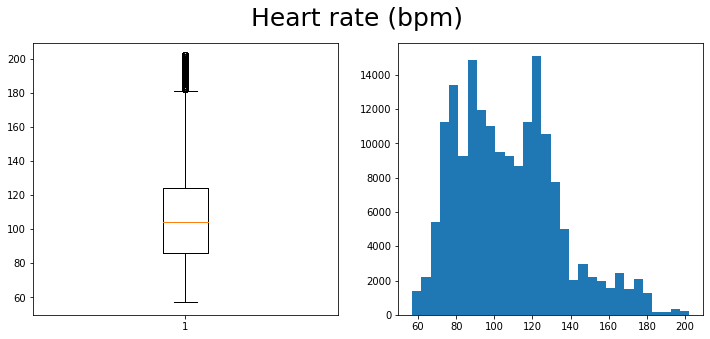

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.boxplot(df['heart_rate'])
plt.subplot(1,2,2)
plt.hist(df['heart_rate'], bins=30)
plt.suptitle('Heart rate (bpm)', fontsize=25)
plt.show()

In [13]:
print('Mean heart rate: ', df['heart_rate'].mean())
print('Standard deviation: ', df['heart_rate'].std())

Mean heart rate:  107.33266034395977
Standard deviation:  26.91534540447778


We see across all the activities the heart rate is on average 107 bpm. Though more strenuous activities register a higher heart rate but the values above 180 bpm are outliers for the sample set that we have. Removal of outliers often helps to train a machine learning model better and have a more generalised model.

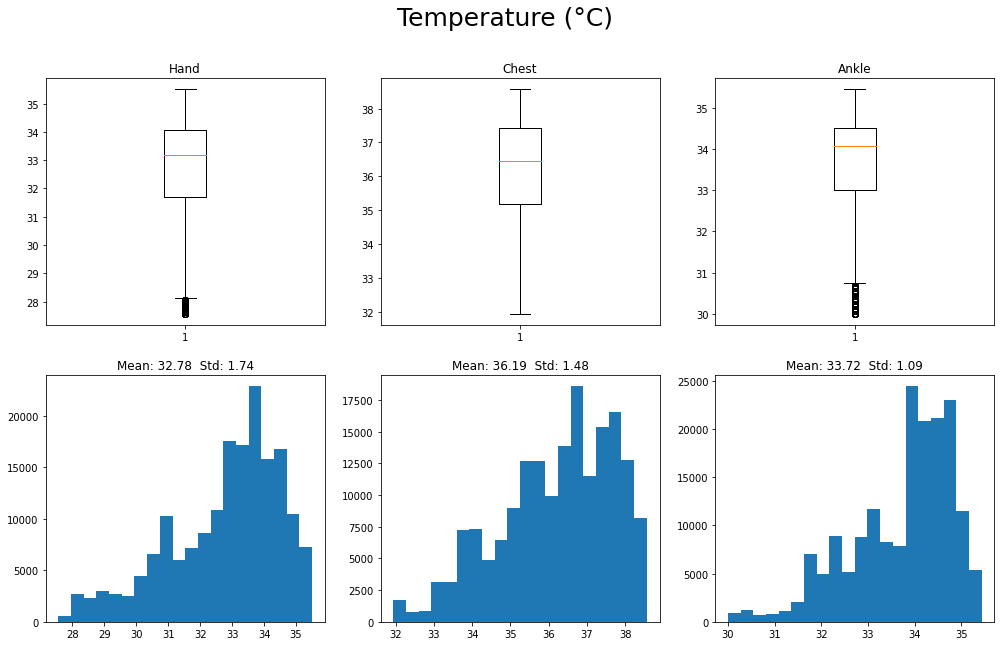

In [14]:
plt.figure(figsize=(17,10))
plt.subplot(2,3,1)
plt.boxplot([x for x in df['IMU_hand_temp'] if x==x])
plt.title('Hand')
plt.subplot(2,3,2)
plt.boxplot([x for x in df['IMU_chest_temp'] if x==x])
plt.title('Chest')
plt.subplot(2,3,3)
plt.boxplot([x for x in df['IMU_ankle_temp'] if x==x])
plt.title('Ankle')
plt.subplot(2,3,4)
plt.hist(df['IMU_hand_temp'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_hand_temp']),2))+'  Std: '+str(round(np.nanstd(df['IMU_hand_temp']),2)))
plt.subplot(2,3,5)
plt.hist(df['IMU_chest_temp'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_chest_temp']),2))+'  Std: '+str(round(np.nanstd(df['IMU_chest_temp']),2)))
plt.subplot(2,3,6)
plt.hist(df['IMU_ankle_temp'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_ankle_temp']),2))+'  Std: '+str(round(np.nanstd(df['IMU_ankle_temp']),2)))

plt.suptitle('Temperature (°C)', fontsize=25)
plt.show()

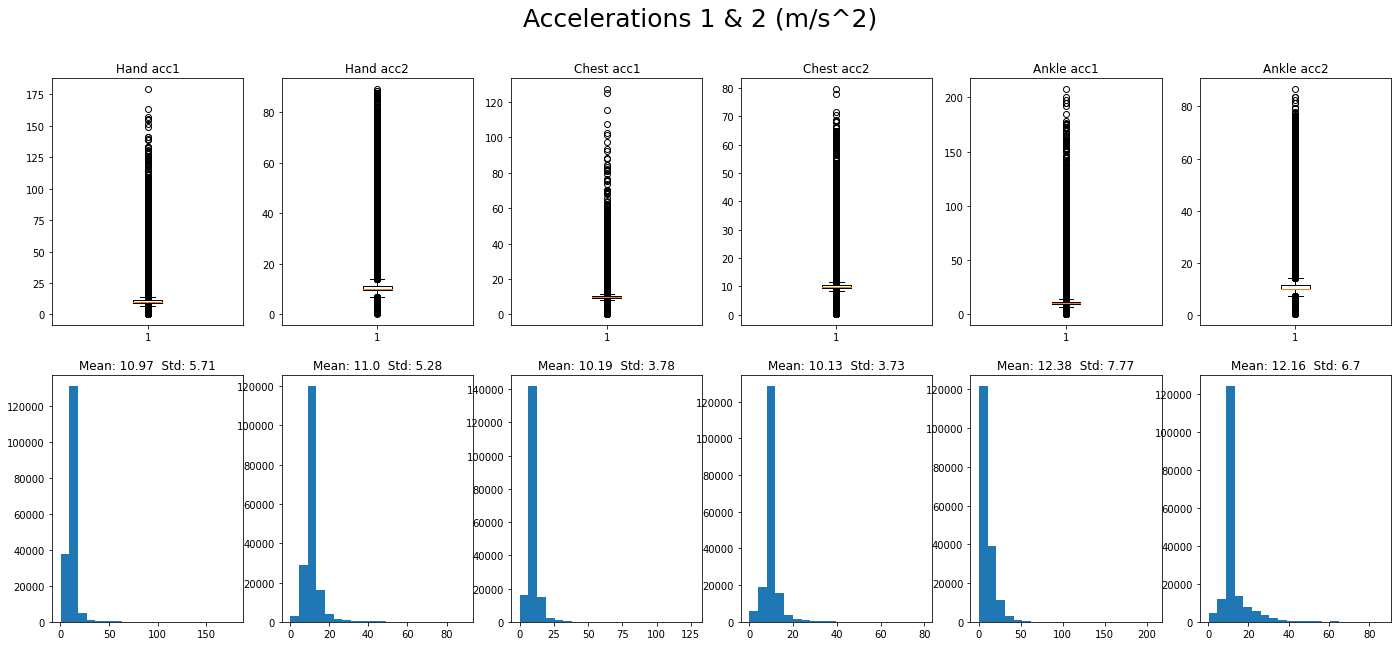

In [15]:
plt.figure(figsize=(24,10))
plt.subplot(2,6,1)
plt.boxplot([x for x in df['IMU_hand_net_acc1'] if x==x])
plt.title('Hand acc1')
plt.subplot(2,6,2)
plt.boxplot([x for x in df['IMU_hand_net_acc2'] if x==x])
plt.title('Hand acc2')
plt.subplot(2,6,3)
plt.boxplot([x for x in df['IMU_chest_net_acc1'] if x==x])
plt.title('Chest acc1')
plt.subplot(2,6,4)
plt.boxplot([x for x in df['IMU_chest_net_acc2'] if x==x])
plt.title('Chest acc2')
plt.subplot(2,6,5)
plt.boxplot([x for x in df['IMU_ankle_net_acc1'] if x==x])
plt.title('Ankle acc1')
plt.subplot(2,6,6)
plt.boxplot([x for x in df['IMU_ankle_net_acc2'] if x==x])
plt.title('Ankle acc2')


plt.subplot(2,6,7)
plt.hist(df['IMU_hand_net_acc1'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_hand_net_acc1']),2))+'  Std: '+str(round(np.nanstd(df['IMU_hand_net_acc1']),2)))
plt.subplot(2,6,8)
plt.hist(df['IMU_hand_net_acc2'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_hand_net_acc2']),2))+'  Std: '+str(round(np.nanstd(df['IMU_hand_net_acc2']),2)))
plt.subplot(2,6,9)
plt.hist(df['IMU_chest_net_acc1'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_chest_net_acc1']),2))+'  Std: '+str(round(np.nanstd(df['IMU_chest_net_acc1']),2)))
plt.subplot(2,6,10)
plt.hist(df['IMU_chest_net_acc2'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_chest_net_acc2']),2))+'  Std: '+str(round(np.nanstd(df['IMU_chest_net_acc2']),2)))
plt.subplot(2,6,11)
plt.hist(df['IMU_ankle_net_acc1'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_ankle_net_acc1']),2))+'  Std: '+str(round(np.nanstd(df['IMU_ankle_net_acc1']),2)))
plt.subplot(2,6,12)
plt.hist(df['IMU_ankle_net_acc2'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_ankle_net_acc2']),2))+'  Std: '+str(round(np.nanstd(df['IMU_ankle_net_acc2']),2)))

plt.suptitle('Accelerations 1 & 2 (m/s^2)', fontsize=25)
plt.show()

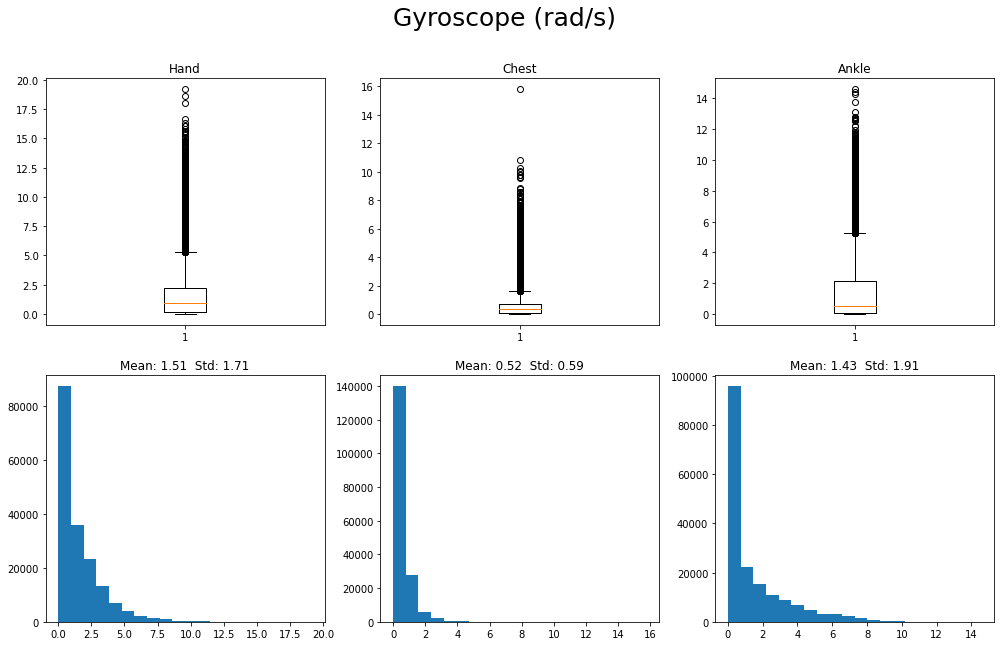

In [16]:
plt.figure(figsize=(17,10))
plt.subplot(2,3,1)
plt.boxplot([x for x in df['IMU_hand_net_gyr'] if x==x])
plt.title('Hand')
plt.subplot(2,3,2)
plt.boxplot([x for x in df['IMU_chest_net_gyr'] if x==x])
plt.title('Chest')
plt.subplot(2,3,3)
plt.boxplot([x for x in df['IMU_ankle_net_gyr'] if x==x])
plt.title('Ankle')
plt.subplot(2,3,4)
plt.hist(df['IMU_hand_net_gyr'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_hand_net_gyr']),2))+'  Std: '+str(round(np.nanstd(df['IMU_hand_net_gyr']),2)))
plt.subplot(2,3,5)
plt.hist(df['IMU_chest_net_gyr'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_chest_net_gyr']),2))+'  Std: '+str(round(np.nanstd(df['IMU_chest_net_gyr']),2)))
plt.subplot(2,3,6)
plt.hist(df['IMU_ankle_net_gyr'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_ankle_net_gyr']),2))+'  Std: '+str(round(np.nanstd(df['IMU_ankle_net_gyr']),2)))

plt.suptitle('Gyroscope (rad/s)', fontsize=25)
plt.show()

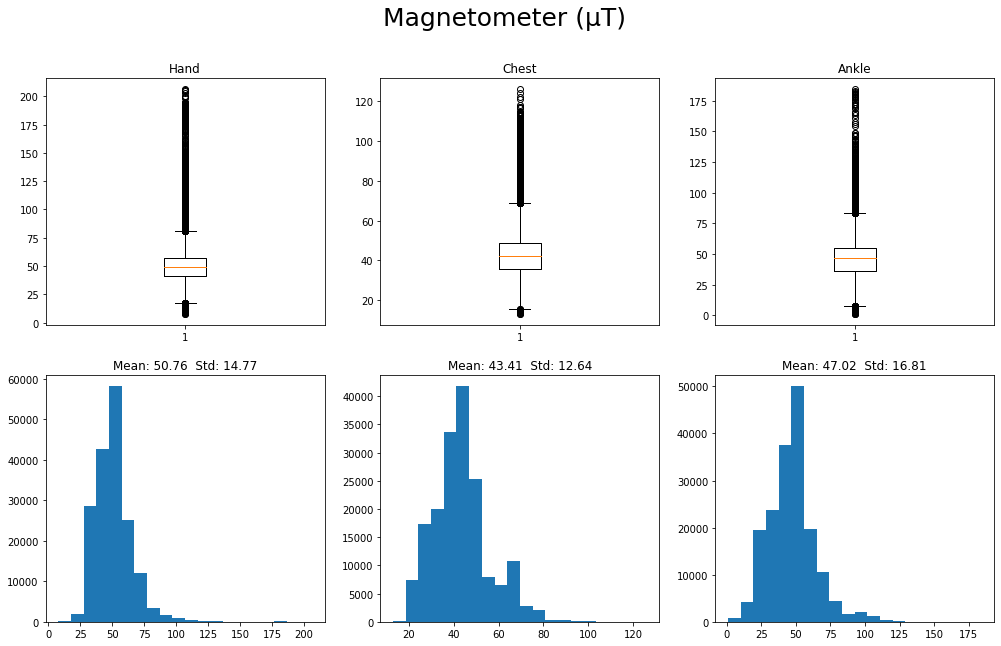

In [17]:
plt.figure(figsize=(17,10))
plt.subplot(2,3,1)
plt.boxplot([x for x in df['IMU_hand_net_mag'] if x==x])
plt.title('Hand')
plt.subplot(2,3,2)
plt.boxplot([x for x in df['IMU_chest_net_mag'] if x==x])
plt.title('Chest')
plt.subplot(2,3,3)
plt.boxplot([x for x in df['IMU_ankle_net_mag'] if x==x])
plt.title('Ankle')
plt.subplot(2,3,4)
plt.hist(df['IMU_hand_net_mag'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_hand_net_mag']),2))+'  Std: '+str(round(np.nanstd(df['IMU_hand_net_mag']),2)))
plt.subplot(2,3,5)
plt.hist(df['IMU_chest_net_mag'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_chest_net_mag']),2))+'  Std: '+str(round(np.nanstd(df['IMU_chest_net_mag']),2)))
plt.subplot(2,3,6)
plt.hist(df['IMU_ankle_net_mag'], bins=20)
plt.title('Mean: '+str(round(np.nanmean(df['IMU_ankle_net_mag']),2))+'  Std: '+str(round(np.nanstd(df['IMU_ankle_net_mag']),2)))

plt.suptitle('Magnetometer (μT)', fontsize=25)
plt.show()

Another subject of interest might be the variation of heart rate with respect to subject age. Since there are 8 subjects in total, we select only 3 subjects here with ages 23 (lowest), 27 and 31 (highest) years for better visualisation.

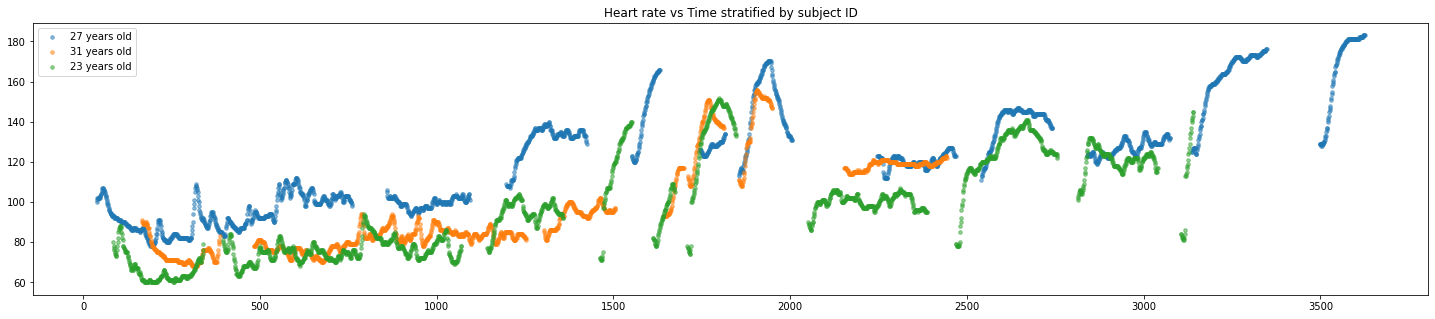

In [18]:
subs = [1, 3, 7]
plt.figure(figsize=(25,5))
for s in subs:
  slc_df = df[df['SubjectID']==s]
  slc_df = slc_df[slc_df.index % 10 == 0]       # to plot every 10th row
  lab = int(slc_df['Age'].unique())
  plt.scatter(slc_df['timestamp'], slc_df['heart_rate'], alpha=0.5, label=str(lab)+' years old', s=13)

plt.title('Heart rate vs Time stratified by subject ID')
plt.legend()
plt.show()

We see that age is not really a factor for heart rate in this case as the mid level age of our dataset registers higher heart rate than both the lowest and the highest aged subjects. Now, we will check if weight and height affect the heart rate. We have merged the weight and height information in a new column called BMI which is the body mass index and is given by weight/height^2. Same as before, we will select the lowest, the highest and a mid level bmi subject for better visualisation.

In [19]:
df['BMI'] = round((df['Weight']*10000)/(df['Height']**2),2)
df['BMI'].unique()

array([25.06, 27.31, 26.31, 25.24, 22.53, 20.6 , 28.73, 27.15])

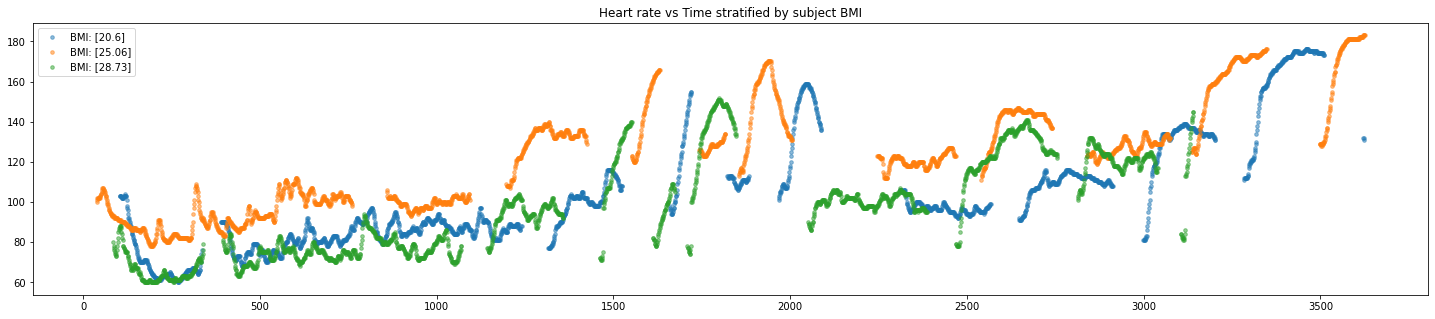

In [20]:
bmi = [20.6, 25.06, 28.73]
plt.figure(figsize=(25,5))

for b in bmi:
  slc_df = df[df['BMI']==b]
  slc_df = slc_df[slc_df.index % 10 == 0]       # to plot every 10th row
  lab = slc_df['BMI'].unique()
  plt.scatter(slc_df['timestamp'], slc_df['heart_rate'], alpha=0.5, label='BMI: '+str(lab), s=13)

plt.title('Heart rate vs Time stratified by subject BMI')
plt.legend()
plt.show()

Same as before, we find that the mid level BMI registers a higher heart rate for the activities than the other 2. We will now try to create a model which will try to predict the heart rate given the other information. Since heart rate is a gradually increasing metric during any activity, our model will try to predict the average heart rate during each activity. For that we need to make a new feature called average_hr that will calculate the average heart rate per activity per subject.

In [21]:
df['avg_hr'] = [0.0]*len(df)

for i in range(9):
  subj_df = df[df['SubjectID']==i]
  for j in list(subj_df['activityID'].unique()):
    subj_act_df = subj_df[subj_df['activityID']==j]
    mean_hr = subj_act_df['heart_rate'].mean()
    for k in range(len(df)):
      if df['SubjectID'].iloc[k]==i and df['activityID'].iloc[k]==j:
        df['avg_hr'].iloc[k]=mean_hr

Our training set will contain data from subjects 1 to 6 while the test set will contain data from subjects 7 and 8, whose average heart rate per activity the model will predict and compare with the true values of average heart rate.

In [32]:
correl = []

for i in list(df.columns.values):
  c = df['avg_hr'].corr(df[i])
  correl.append(round(c,2))

abs_corr = [abs(x) for x in correl]

corr_df = pd.DataFrame({'Correlation': correl, 'Absolute correlation': abs_corr}, index=list(df.columns.values))
corr_df.sort_values('Absolute correlation', ascending=False)

,Correlation,Absolute correlation
avg_hr,1.00,1.00
heart_rate,0.92,0.92
timestamp,0.85,0.85
MET,0.84,0.84
IMU_chest_net_gyr,0.56,0.56
IMU_hand_net_gyr,0.55,0.55
IMU_ankle_net_gyr,0.55,0.55
IMU_hand_temp,-0.40,0.40
IMU_chest_net_mag,0.36,0.36
IMU_ankle_net_acc2,0.34,0.34


In [33]:
train1 = df[df['SubjectID']<=2]
train2 = df[df['SubjectID']>4]
train = pd.concat([train1, train2])

mid_test = df[df['SubjectID']>2]
test = mid_test[mid_test['SubjectID']<5]

In [34]:
# splitting x_train, x_test, y_train and y_test

x_train = train[['timestamp', 'activityID', 'IMU_hand_temp',
       'IMU_hand_net_acc1', 'IMU_hand_net_acc2', 'IMU_hand_net_gyr',
       'IMU_hand_net_mag', 'IMU_chest_net_acc1', 'IMU_chest_net_acc2',
       'IMU_chest_net_gyr', 'IMU_chest_net_mag', 'IMU_ankle_net_acc1',
       'IMU_ankle_net_acc2', 'IMU_ankle_net_gyr', 'IMU_ankle_net_mag',
        'MET']]

y_train = train['avg_hr']

x_test = test[['timestamp', 'activityID', 'IMU_hand_temp',
       'IMU_hand_net_acc1', 'IMU_hand_net_acc2', 'IMU_hand_net_gyr',
       'IMU_hand_net_mag', 'IMU_chest_net_acc1', 'IMU_chest_net_acc2',
       'IMU_chest_net_gyr', 'IMU_chest_net_mag', 'IMU_ankle_net_acc1',
       'IMU_ankle_net_acc2', 'IMU_ankle_net_gyr', 'IMU_ankle_net_mag',
        'MET']]

y_test = test['avg_hr']

x_vals = x_test['timestamp']

In [35]:
to_drop = ['activityID', 'MET']

tr_aid = list(x_train['activityID'])
tr_mt = list(x_train['MET'])

te_aid = list(x_test['activityID'])
te_mt = list(x_test['MET'])

In [36]:
x_train.drop(labels=to_drop, axis=1, inplace=True)
x_test.drop(labels=to_drop, axis=1, inplace=True)

As our dataset contains several Nan values, we will impute them by MICE (Multiple Imputation by Chained Equations) technique which uses a linear regression algorithm.

In [37]:
imp_reg = LinearRegression()
imp = IterativeImputer(estimator=imp_reg, sample_posterior=False, verbose=2, max_iter=300, tol=1e-10, imputation_order='roman')

In [38]:
x_train = pd.DataFrame(imp.fit_transform(x_train))
x_test = pd.DataFrame(imp.transform(x_test))

[IterativeImputer] Completing matrix with shape (139741, 14)
[IterativeImputer] Ending imputation round 1/300, elapsed time 1.28
[IterativeImputer] Change: 58.67201593958309, scaled tolerance: 4.2456499999999996e-07 
[IterativeImputer] Ending imputation round 2/300, elapsed time 2.44
[IterativeImputer] Change: 18.31701159644227, scaled tolerance: 4.2456499999999996e-07 
[IterativeImputer] Ending imputation round 3/300, elapsed time 3.53
[IterativeImputer] Change: 14.351896734312074, scaled tolerance: 4.2456499999999996e-07 
[IterativeImputer] Ending imputation round 4/300, elapsed time 4.64
[IterativeImputer] Change: 11.2435199957496, scaled tolerance: 4.2456499999999996e-07 
[IterativeImputer] Ending imputation round 5/300, elapsed time 5.74
[IterativeImputer] Change: 8.774672417073273, scaled tolerance: 4.2456499999999996e-07 
[IterativeImputer] Ending imputation round 6/300, elapsed time 6.88
[IterativeImputer] Change: 6.8461986759051126, scaled tolerance: 4.2456499999999996e-07 
[I

In [39]:
x_train['activityID'] = tr_aid
x_train['MET'] = tr_mt

x_test['activityID'] = te_aid
x_test['MET'] = te_mt

In [40]:
# scaling the training and test sets

scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

We will use K nearest neighbor regressor to predict the values. But we want to perform hyperparameter tuning to identify the best hyperparameters of our model and also perform 3 fold cross validation on the training set to determine the best set of hyperparameter values. We will use Randomized search CV to select 10 random combinations of hyperparameters and select the combination that gives the highest accuracy.

In [41]:
# setting list of hyperparameter values for our regression model

n_neighbors = [x for x in list(range(5, 256, 50))]
weights = ['uniform', 'distance']
leaf_size = [10, 30, 50, 100]
n_jobs = [-1]
p = [1, 2]

knn_grid = {'n_neighbors': n_neighbors,
            'weights': weights,
            'leaf_size': leaf_size,
            'n_jobs': n_jobs,
            'p': p}

In [43]:
knn_cv = KNeighborsRegressor()
knn_random = RandomizedSearchCV(estimator=knn_cv, param_distributions=knn_grid, n_iter=10, scoring='neg_mean_absolute_error', cv=3, verbose=2)
knn_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END leaf_size=10, n_jobs=-1, n_neighbors=55, p=2, weights=uniform; total time= 3.7min
[CV] END leaf_size=10, n_jobs=-1, n_neighbors=55, p=2, weights=uniform; total time= 3.9min
[CV] END leaf_size=10, n_jobs=-1, n_neighbors=55, p=2, weights=uniform; total time= 3.4min
[CV] END leaf_size=30, n_jobs=-1, n_neighbors=5, p=1, weights=distance; total time= 5.0min
[CV] END leaf_size=30, n_jobs=-1, n_neighbors=5, p=1, weights=distance; total time= 7.0min
[CV] END leaf_size=30, n_jobs=-1, n_neighbors=5, p=1, weights=distance; total time= 6.7min
[CV] END leaf_size=10, n_jobs=-1, n_neighbors=155, p=2, weights=distance; total time= 2.6min
[CV] END leaf_size=10, n_jobs=-1, n_neighbors=155, p=2, weights=distance; total time= 2.8min
[CV] END leaf_size=10, n_jobs=-1, n_neighbors=155, p=2, weights=distance; total time= 2.8min
[CV] END leaf_size=30, n_jobs=-1, n_neighbors=5, p=2, weights=distance; total time= 2.7min
[CV] END leaf_size=30, 

RandomizedSearchCV(cv=3, estimator=KNeighborsRegressor(),
                   param_distributions={'leaf_size': [10, 30, 50, 100],
                                        'n_jobs': [-1],
                                        'n_neighbors': [5, 55, 105, 155, 205,
                                                        255],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='neg_mean_absolute_error', verbose=2)

Using the best parameters from above, we will train our model using the best estimator that we got in the last step.

In [44]:
model = knn_random.best_estimator_
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

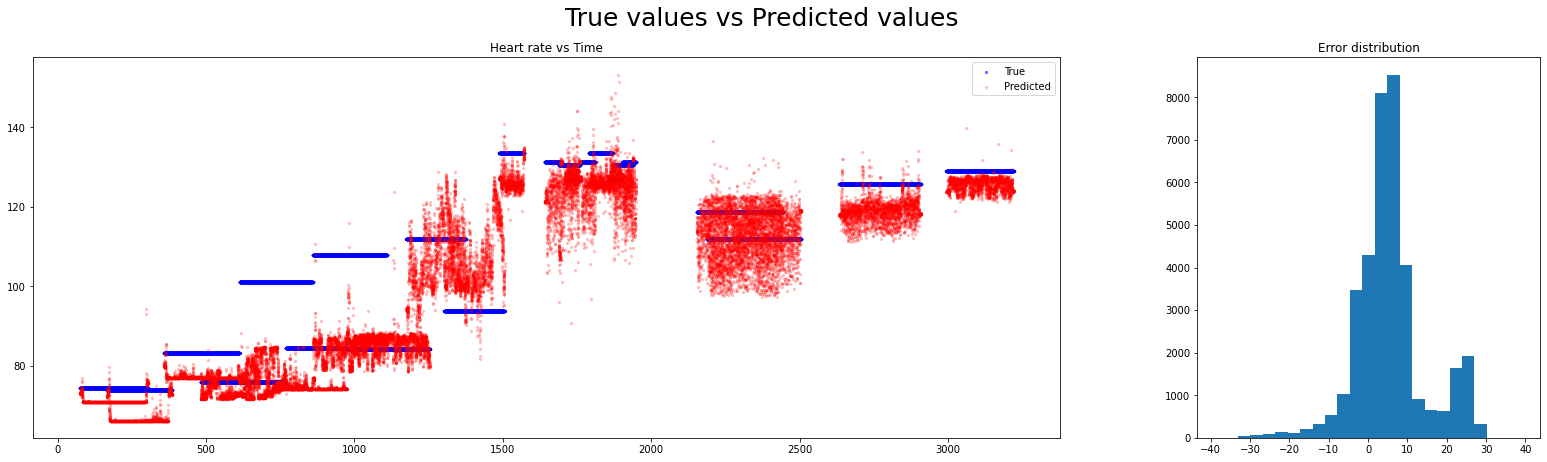

In [45]:
fig, axs = plt.subplots(1,2,figsize=(27,7), gridspec_kw={'width_ratios': [3, 1]})
axs[0].scatter(x_vals, y_test, color='blue', alpha=0.5, s=5, label='True')
axs[0].scatter(x_vals, y_pred, color='red', alpha=0.2, s=5, label='Predicted')
axs[0].legend()
axs[0].set_title('Heart rate vs Time')

axs[1].hist(y_test-y_pred, bins=25)
axs[1].set_title('Error distribution')

plt.suptitle('True values vs Predicted values', fontsize=25)
plt.show()

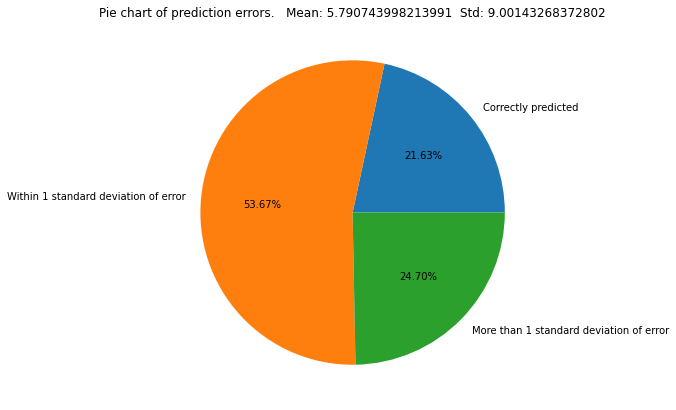

In [46]:
err = y_test-y_pred
data = [len([x for x in err if x<=0.1]), len([x for x in err if x>0.1 and x<=err.std()]), len([x for x in err if x>err.std()])]
labels = ['Correctly predicted', 'Within 1 standard deviation of error', 'More than 1 standard deviation of error']
plt.figure(figsize=(7,7))
plt.pie(data, labels=labels, autopct='%.2f%%')
plt.title('Pie chart of prediction errors.   Mean: '+str(err.mean())+'  Std: '+str(err.std()))
plt.show()

In [47]:
rms_error = (metrics.mean_squared_error(y_test, y_pred))**0.5
print('Root mean squared error', rms_error)

Root mean squared error 10.703098680701851
